# dre_reverberation_algorithm

In [1]:
from math import pi
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import wavio
import IPython

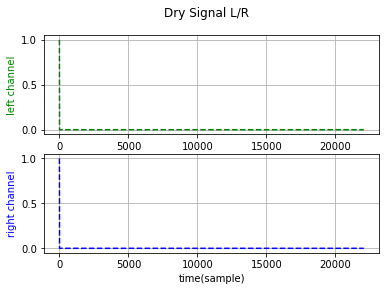

In [2]:
sr = 44100

wav = wavio.read("dirac16_44_stereo.wav")
left_channel = wav.data[:, 0] / 32767.0
right_channel = wav.data[:, 1] / 32767.0

x_axis = np.arange(len(left_channel))

plt.figure(1)
plt.suptitle('Dry Signal L/R')

plt.subplot(211)
plt.plot(x_axis, left_channel, 'g--')
plt.ylabel('left channel', color='g')
plt.grid()

plt.subplot(212)
plt.plot(x_axis, right_channel, 'b--')
plt.ylabel('right channel', color='b')
plt.grid()

plt.xlabel(r'time(sample)')

plt.show()

IPython.display.display(IPython.display.Audio("dirac16_44_stereo.wav", rate=sr))

In [3]:
#left_input = left_channel * 0.2 + right_channel * 0.05
#right_input = left_channel * 0.05 + right_channel * 0.2

left_input = left_channel
right_input = right_channel


#time = np.array([0.0000, 0.0043, 0.0215, 0.0225, 0.0268, 
#                 0.0270, 0.0298, 0.0458, 0.0485, 0.0572,
#                 0.0587, 0.0595, 0.0612, 0.0707, 0.0708,
#                 0.0726, 0.0741, 0.0753, 0.0797])

#gain = np.array([1.000, 0.841, 0.504, 0.491, 0.379,
#                 0.380, 0.346, 0.289, 0.272, 0.192,
#                 0.193, 0.217, 0.181, 0.180, 0.181,
#                 0.176, 0.142, 0.167, 0.134])

#sample = np.around(time*sr).astype(int)


time = np.array([1, 955, 1055, 1699, 1867, 1987, 3055, 3321])

gain = np.array([0.5, 0.45, 0.06, 0.4, 0.3, 0.3, 0.13, 0.12])

sample = np.around(time).astype(int)

numerator = np.zeros(int(sample[-1])+1)
denominator = 1

for i in range(0, len(sample)):
    numerator[sample[i]] = gain[i]
    
left_output = scipy.signal.lfilter(numerator, denominator, left_input)
#right_output = scipy.signal.lfilter(numerator, denominator, right_input)

left_tdl_output = left_output
right_tdl_output = right_input

tdl_output = np.zeros((len(left_tdl_output), 2))
tdl_output[:, 0] = left_tdl_output
tdl_output[:, 1] = right_tdl_output
wavio.write("tdl_test_output.wav", tdl_output, sr, sampwidth=2)

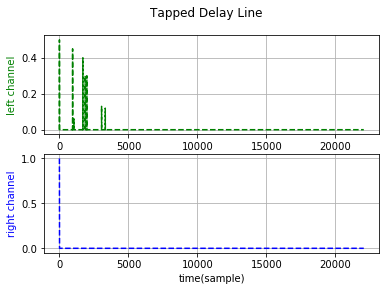

In [4]:
x_axis = np.arange(len(left_tdl_output))

plt.figure(1)
plt.suptitle('Tapped Delay Line')

plt.subplot(211)
plt.plot(x_axis, left_tdl_output, 'g--')
plt.ylabel('left channel', color='g')
plt.grid()

plt.subplot(212)
plt.plot(x_axis, right_tdl_output, 'b--')
plt.ylabel('right channel', color='b')
plt.grid()

plt.xlabel(r'time(sample)')

plt.show()

IPython.display.display(IPython.display.Audio("tdl_test_output.wav", rate=sr))

In [13]:
lbcf_delaylist = np.array([2200, 2926, 2956, 3744])
roomsize = np.array([0.45, 0.49, 0.52, 0.39])
damp = np.array([0.45, 0.42, 0.39, 0.36])

left_lbcf_output = []
right_lbcf_output = []

for i in range(len(lbcf_delaylist)):
    delaysample = lbcf_delaylist[i]
    arraysize = delaysample + 1

    numerator = np.zeros(arraysize + 1)
    denominator = np.zeros(arraysize)

    numerator[arraysize-1] = 1
    numerator[arraysize] = -damp[i]

    denominator[0] = 1
    denominator[1] = -damp[i]
    denominator[arraysize-1] = -roomsize[i]*(1-damp[i])

    left_ch = scipy.signal.lfilter(numerator, denominator, left_input)
    left_lbcf_output.append(left_ch)
    
    right_ch = scipy.signal.lfilter(numerator, denominator, right_input)
    right_lbcf_output.append(right_ch)

left_lbcf_output = sum(left_lbcf_output)
left_lbcf_output = left_lbcf_output/len(lbcf_delaylist)

right_lbcf_output = sum(right_lbcf_output)
right_lbcf_output = right_lbcf_output/len(lbcf_delaylist)

lbcf_output = np.zeros((len(left_lbcf_output), 2))
lbcf_output[:, 0] = left_lbcf_output
lbcf_output[:, 1] = right_input
wavio.write("lbcf_output.wav", lbcf_output, sr, sampwidth=3)

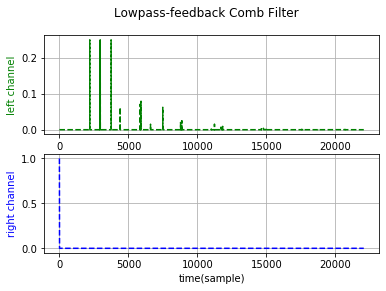

In [15]:
x_axis = np.arange(len(left_lbcf_output))

plt.figure(1)
plt.suptitle('Lowpass-feedback Comb Filter')

plt.subplot(211)
plt.plot(x_axis, left_lbcf_output, 'g--')
plt.ylabel('left channel', color='g')
plt.grid()

plt.subplot(212)
plt.plot(x_axis, right_input, 'b--')
plt.ylabel('right channel', color='b')
plt.grid()

plt.xlabel(r'time(sample)')

plt.show()

IPython.display.display(IPython.display.Audio("lbcf_output.wav", rate=sr))

In [16]:
g = 0.7
apf_delaylist = np.array([1201])

left_apf_output = left_lbcf_output
right_apf_output = right_lbcf_output

for i in range(len(apf_delaylist)):
    delaysample = apf_delaylist[i]
    arraysize = delaysample+1

    numerator = np.zeros(arraysize)
    denominator = np.zeros(arraysize)
    
    numerator[0] = g
    numerator[delaysample] = 1

    denominator[0] = 1
    denominator[delaysample] = g
    
    left_apf_output = scipy.signal.lfilter(numerator, denominator, left_apf_output)
    right_apf_output = scipy.signal.lfilter(numerator, denominator, right_apf_output)

apf_output = np.zeros((len(left_apf_output), 2))
apf_output[:, 0] = left_apf_output
apf_output[:, 1] = right_apf_output
wavio.write("apf_output.wav", apf_output, sr, sampwidth=3)

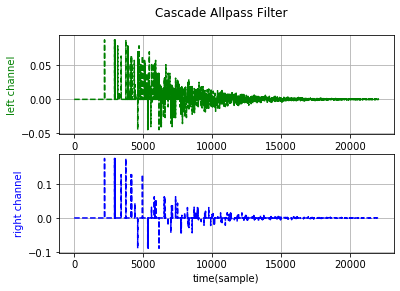

In [8]:
x_axis = np.arange(len(left_apf_output))

plt.figure(1)
plt.suptitle('Cascade Allpass Filter')

plt.subplot(211)
plt.plot(x_axis, left_apf_output, 'g--')
plt.ylabel('left channel', color='g')
plt.grid()

plt.subplot(212)
plt.plot(x_axis, right_apf_output, 'b--')
plt.ylabel('right channel', color='b')
plt.grid()

plt.xlabel(r'time(sample)')

plt.show()

IPython.display.display(IPython.display.Audio("apf_output.wav", rate=sr))

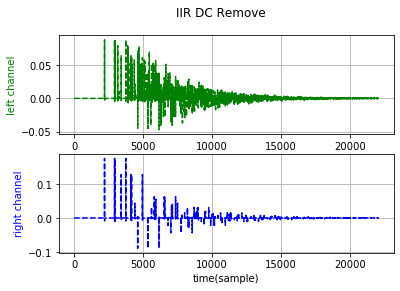

In [9]:
numerator= [1, -1]
denominator = [1, -0.95]

left_rmdc = scipy.signal.lfilter(numerator, denominator, left_apf_output)
right_rmdc = scipy.signal.lfilter(numerator, denominator, right_apf_output)

rmdc = np.zeros((len(left_rmdc), 2))
rmdc[:, 0] = left_rmdc
rmdc[:, 1] = right_rmdc
wavio.write("rmdc.wav", rmdc, sr, sampwidth=3)

x_axis = np.arange(len(left_rmdc))

plt.figure(1)
plt.suptitle('IIR DC Remove')

plt.subplot(211)
plt.plot(x_axis, left_rmdc, 'g--')
plt.ylabel('left channel', color='g')
plt.grid()

plt.subplot(212)
plt.plot(x_axis, right_rmdc, 'b--')
plt.ylabel('right channel', color='b')
plt.grid()

plt.xlabel(r'time(sample)')

plt.show()

IPython.display.display(IPython.display.Audio("rmdc.wav", rate=sr))

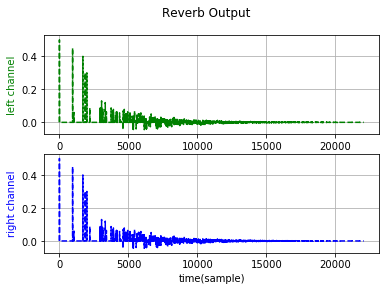

In [10]:
left_reverb = left_apf_output + left_tdl_output
#right_reverb = right_apf_output + right_tdl_output

reverb = np.zeros((len(left_reverb), 2))
reverb[:, 0] = left_reverb
reverb[:, 1] = left_reverb
wavio.write("reverb.wav", reverb, sr, sampwidth=3)

x_axis = np.arange(len(left_reverb))

plt.figure(1)
plt.suptitle('Reverb Output')

plt.subplot(211)
plt.plot(x_axis, left_reverb, 'g--')
plt.ylabel('left channel', color='g')
plt.grid()

plt.subplot(212)
plt.plot(x_axis, left_reverb, 'b--')
plt.ylabel('right channel', color='b')
plt.grid()

plt.xlabel(r'time(sample)')

plt.show()

IPython.display.display(IPython.display.Audio("reverb.wav", rate=sr))